In [41]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
!mkdir -p /content/drive/MyDrive/IIIT_Assignment2/data

In [43]:
%cd /content/drive/MyDrive/IIIT_Assignment2

/content/drive/MyDrive/IIIT_Assignment2


In [44]:
!mkdir -p src notebooks results

In [45]:
!ls -R /content/drive/MyDrive/IIIT_Assignment2

/content/drive/MyDrive/IIIT_Assignment2:
data  notebooks  results  src

/content/drive/MyDrive/IIIT_Assignment2/data:
Pride_and_Prejudice-Jane_Austen.txt

/content/drive/MyDrive/IIIT_Assignment2/notebooks:

/content/drive/MyDrive/IIIT_Assignment2/results:
best_model.pth	model_bestfit_long.pth	model_best.pth	   model_underfit.pth
loss_plot.png	model_bestfit.pth	model_overfit.pth

/content/drive/MyDrive/IIIT_Assignment2/src:
data_utils.py  model.py  __pycache__  train.py	utils.py

/content/drive/MyDrive/IIIT_Assignment2/src/__pycache__:
data_utils.cpython-312.pyc  train.cpython-312.pyc
model.cpython-312.pyc	    utils.cpython-312.pyc


In [46]:
import torch
x = torch.randn(2,3).cuda() if torch.cuda.is_available() else torch.randn(2,3)
print("Torch OK. CUDA available:", torch.cuda.is_available())
print(x)


Torch OK. CUDA available: True
tensor([[-0.0881,  0.2094, -0.2849],
        [ 0.2591, -0.1471,  0.9826]], device='cuda:0')


In [47]:
%%writefile /content/drive/MyDrive/IIIT_Assignment2/src/data_utils.py
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import re

# -------------------------------
# 1. Tokenizer
# -------------------------------
def tokenize(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text.split()

# -------------------------------
# 2. Vocabulary builder
# -------------------------------
def build_vocab(text, min_freq=2):
    tokens = tokenize(text)
    freq = Counter(tokens)
    vocab = {'<pad>':0, '<unk>':1}
    for word, count in freq.items():
        if count >= min_freq:
            vocab[word] = len(vocab)
    return vocab

# -------------------------------
# 3. Encode text
# -------------------------------
def encode_text(text, vocab):
    tokens = tokenize(text)
    return [vocab.get(token, vocab['<unk>']) for token in tokens]

# -------------------------------
# 4. PyTorch Dataset
# -------------------------------
class LanguageModelDataset(Dataset):
    def __init__(self, encoded_data, seq_len):
        self.seq_len = seq_len
        self.data = encoded_data

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx:idx+self.seq_len])
        y = torch.tensor(self.data[idx+1:idx+self.seq_len+1])
        return x, y

# -------------------------------
# 5. Create train & validation loaders
# -------------------------------
def create_dataloaders(encoded_data, seq_len=30, batch_size=64, split_ratio=0.9):
    n = int(len(encoded_data)*split_ratio)
    train_data, val_data = encoded_data[:n], encoded_data[n:]
    train_ds = LanguageModelDataset(train_data, seq_len)
    val_ds = LanguageModelDataset(val_data, seq_len)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)
    return train_loader, val_loader


Overwriting /content/drive/MyDrive/IIIT_Assignment2/src/data_utils.py


In [48]:
# %load /content/drive/MyDrive/IIIT_Assignment2/src/train.py
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import os

from src.model import LSTMLanguageModel

def train_model(train_loader, val_loader, vocab_size,
                embed_dim=128, hidden_dim=256, num_layers=2,
                dropout=0.3, lr=0.001, num_epochs=5,
                device="cuda" if torch.cuda.is_available() else "cpu",
                save_path="/content/drive/MyDrive/IIIT_Assignment2/results/best_model.pth"):

    model = LSTMLanguageModel(vocab_size, embed_dim, hidden_dim, num_layers, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    best_val_loss = float("inf")

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch} Training"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out, _ = model(x)
            loss = criterion(out.view(-1, vocab_size), y.view(-1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_loss = epoch_loss / len(train_loader)

        # --- Validation ---
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out, _ = model(x)
                loss = criterion(out.view(-1, vocab_size), y.view(-1))
                val_loss += loss.item()
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val PPL={math.exp(val_loss):.2f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)

    # --- Plot training vs validation loss ---
    plt.figure(figsize=(6,4))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.savefig("/content/drive/MyDrive/IIIT_Assignment2/results/loss_plot.png")
    plt.show()

    print("✅ Training complete. Best Val Perplexity:", math.exp(best_val_loss))


In [49]:
train_loader, val_loader = create_dataloaders(encoded, seq_len=5)
print("✅ Data utils working correctly!")


✅ Data utils working correctly!


In [50]:
from src.data_utils import build_vocab, encode_text, create_dataloaders

# Path to dataset (make sure file name matches exactly)
dataset_path = "/content/drive/MyDrive/IIIT_Assignment2/data/Pride_and_Prejudice-Jane_Austen.txt"

# 1. Load the text
with open(dataset_path, "r", encoding="utf-8") as f:
    text_data = f.read()

print("✅ Loaded dataset successfully!")
print("Total characters:", len(text_data))
print("\nSample text preview:\n", text_data[:400])

# 2. Build vocabulary
vocab = build_vocab(text_data, min_freq=3)
print("\n✅ Vocabulary size:", len(vocab))

# 3. Encode text
encoded = encode_text(text_data, vocab)
print("✅ Encoded text length:", len(encoded))

# 4. Create train & validation DataLoaders
train_loader, val_loader = create_dataloaders(encoded, seq_len=30, batch_size=64)

for x, y in train_loader:
    print("✅ One batch shape:", x.shape, y.shape)
    break


✅ Loaded dataset successfully!
Total characters: 711331

Sample text preview:
 The Project Gutenberg eBook, Pride and Prejudice, by Jane Austen, Edited
by R. W. (Robert William) Chapman


This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.org





Title: Pride and Prejudice


Author: 

✅ Vocabulary size: 3164
✅ Encoded text length: 124917
✅ One batch shape: torch.Size([64, 30]) torch.Size([64, 30])


In [51]:
%%writefile /content/drive/MyDrive/IIIT_Assignment2/src/model.py
import torch
import torch.nn as nn

class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256, num_layers=2, dropout=0.3):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embed(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        return out, hidden

    def generate(self, start_seq, vocab, idx2word, max_len=50, device="cpu"):
        self.eval()
        words = start_seq.split()
        input_seq = torch.tensor([[vocab.get(w, vocab["<unk>"]) for w in words]],
                                 dtype=torch.long).to(device)
        hidden = None
        for _ in range(max_len):
            output, hidden = self.forward(input_seq, hidden)
            next_token = torch.argmax(output[:, -1, :], dim=-1)
            next_word = idx2word[next_token.item()]
            words.append(next_word)
            input_seq = torch.cat([input_seq, next_token.unsqueeze(0)], dim=1)
        return " ".join(words)


Overwriting /content/drive/MyDrive/IIIT_Assignment2/src/model.py


In [52]:
from src.model import LSTMLanguageModel

vocab_size = 3164  # use the same vocab size from your preprocessing
model = LSTMLanguageModel(vocab_size)

print(model)
sample_input = torch.randint(0, vocab_size, (64, 30))
out, hidden = model(sample_input)
print("Output shape:", out.shape)


LSTMLanguageModel(
  (embed): Embedding(3164, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=256, out_features=3164, bias=True)
)
Output shape: torch.Size([64, 30, 3164])


In [53]:
%%writefile /content/drive/MyDrive/IIIT_Assignment2/src/train.py
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import os

from src.model import LSTMLanguageModel

def train_model(train_loader, val_loader, vocab_size,
                embed_dim=128, hidden_dim=256, num_layers=2,
                dropout=0.3, lr=0.001, num_epochs=5,
                device="cuda" if torch.cuda.is_available() else "cpu",
                save_path="/content/drive/MyDrive/IIIT_Assignment2/results/best_model.pth"):

    model = LSTMLanguageModel(vocab_size, embed_dim, hidden_dim, num_layers, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    best_val_loss = float("inf")

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch} Training"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out, _ = model(x)
            loss = criterion(out.view(-1, vocab_size), y.view(-1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_loss = epoch_loss / len(train_loader)

        # --- Validation ---
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out, _ = model(x)
                loss = criterion(out.view(-1, vocab_size), y.view(-1))
                val_loss += loss.item()
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val PPL={math.exp(val_loss):.2f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)

    # --- Plot training vs validation loss ---
    plt.figure(figsize=(6,4))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.savefig("/content/drive/MyDrive/IIIT_Assignment2/results/loss_plot.png")
    plt.show()

    print("✅ Training complete. Best Val Perplexity:", math.exp(best_val_loss))


Overwriting /content/drive/MyDrive/IIIT_Assignment2/src/train.py


Epoch 1 Training: 100%|██████████| 1757/1757 [00:18<00:00, 97.30it/s]


Epoch 1: Train Loss=5.1819, Val Loss=5.6397, Val PPL=281.37


Epoch 2 Training: 100%|██████████| 1757/1757 [00:17<00:00, 97.92it/s]


Epoch 2: Train Loss=4.2754, Val Loss=5.8089, Val PPL=333.25


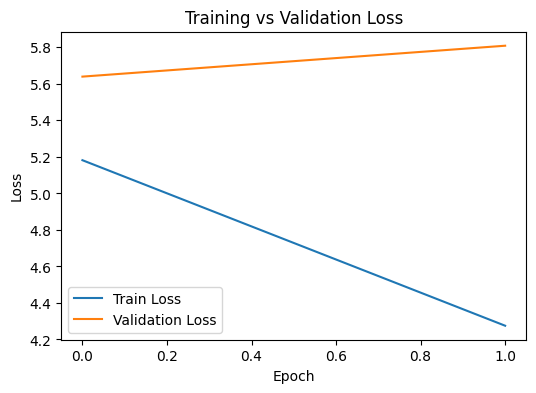

✅ Training complete. Best Val Perplexity: 281.37266941417107


In [54]:
from src.train import train_model

# Use same vocab, train_loader, val_loader
train_model(train_loader, val_loader, vocab_size=len(vocab), num_epochs=2)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
Epoch 1 Training: 100%|██████████| 1757/1757 [00:07<00:00, 226.63it/s]


Epoch 1: Train Loss=4.5155, Val Loss=5.9077, Val PPL=367.87


Epoch 2 Training: 100%|██████████| 1757/1757 [00:07<00:00, 228.85it/s]


Epoch 2: Train Loss=3.6905, Val Loss=6.5066, Val PPL=669.56


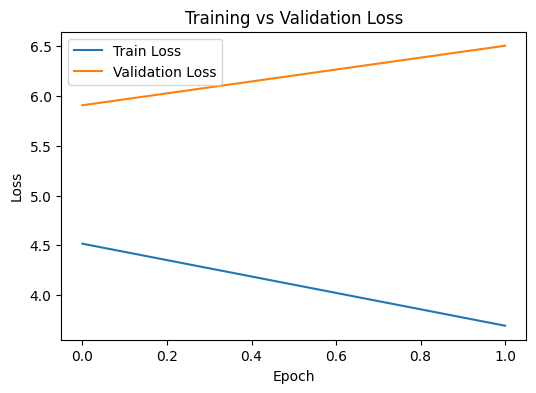

✅ Training complete. Best Val Perplexity: 367.8667993116118


In [55]:
from src.train import train_model

train_model(
    train_loader, val_loader, vocab_size=len(vocab),
    embed_dim=64, hidden_dim=64, num_layers=1,
    dropout=0.2, lr=0.005, num_epochs=2,
    save_path="/content/drive/MyDrive/IIIT_Assignment2/results/model_underfit.pth"
)


Epoch 1 Training: 100%|██████████| 1757/1757 [00:55<00:00, 31.66it/s]


Epoch 1: Train Loss=5.3689, Val Loss=5.8403, Val PPL=343.89


Epoch 2 Training: 100%|██████████| 1757/1757 [00:56<00:00, 31.32it/s]


Epoch 2: Train Loss=4.0685, Val Loss=6.5092, Val PPL=671.31


Epoch 3 Training: 100%|██████████| 1757/1757 [00:56<00:00, 31.10it/s]


Epoch 3: Train Loss=2.8211, Val Loss=8.0899, Val PPL=3261.30


Epoch 4 Training: 100%|██████████| 1757/1757 [00:56<00:00, 31.04it/s]


Epoch 4: Train Loss=1.7366, Val Loss=9.8276, Val PPL=18538.49


Epoch 5 Training: 100%|██████████| 1757/1757 [00:56<00:00, 31.07it/s]


Epoch 5: Train Loss=1.0317, Val Loss=11.2879, Val PPL=79853.05


Epoch 6 Training: 100%|██████████| 1757/1757 [00:56<00:00, 31.25it/s]


Epoch 6: Train Loss=0.6860, Val Loss=12.3277, Val PPL=225872.98


Epoch 7 Training: 100%|██████████| 1757/1757 [00:56<00:00, 31.08it/s]


Epoch 7: Train Loss=0.5406, Val Loss=13.0492, Val PPL=464707.34


Epoch 8 Training: 100%|██████████| 1757/1757 [00:56<00:00, 31.21it/s]


Epoch 8: Train Loss=0.4708, Val Loss=13.6821, Val PPL=875063.39


Epoch 9 Training: 100%|██████████| 1757/1757 [00:56<00:00, 31.23it/s]


Epoch 9: Train Loss=0.4289, Val Loss=14.0568, Val PPL=1272902.43


Epoch 10 Training: 100%|██████████| 1757/1757 [00:56<00:00, 31.24it/s]


Epoch 10: Train Loss=0.4003, Val Loss=14.4715, Val PPL=1927061.27


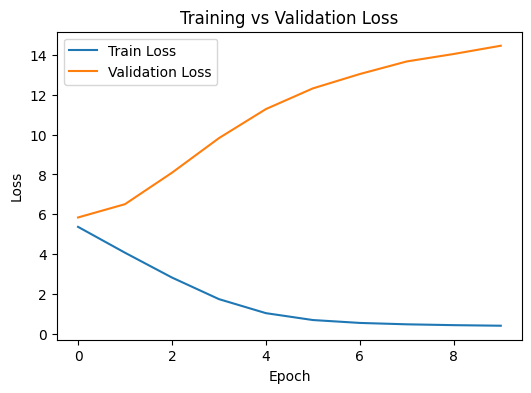

✅ Training complete. Best Val Perplexity: 343.8925809212108


In [56]:
train_model(
    train_loader, val_loader, vocab_size=len(vocab),
    embed_dim=256, hidden_dim=512, num_layers=3,
    dropout=0.0, lr=0.001, num_epochs=10,
    save_path="/content/drive/MyDrive/IIIT_Assignment2/results/model_overfit.pth"
)


Epoch 1 Training: 100%|██████████| 1757/1757 [00:18<00:00, 94.79it/s]


Epoch 1: Train Loss=5.2224, Val Loss=5.6325, Val PPL=279.36


Epoch 2 Training: 100%|██████████| 1757/1757 [00:18<00:00, 92.99it/s]


Epoch 2: Train Loss=4.3109, Val Loss=5.7577, Val PPL=316.61


Epoch 3 Training: 100%|██████████| 1757/1757 [00:18<00:00, 94.27it/s]


Epoch 3: Train Loss=3.6816, Val Loss=6.1941, Val PPL=489.83


Epoch 4 Training: 100%|██████████| 1757/1757 [00:18<00:00, 92.98it/s]


Epoch 4: Train Loss=3.1227, Val Loss=6.6651, Val PPL=784.51


Epoch 5 Training: 100%|██████████| 1757/1757 [00:18<00:00, 93.79it/s]


Epoch 5: Train Loss=2.6874, Val Loss=7.1436, Val PPL=1266.00


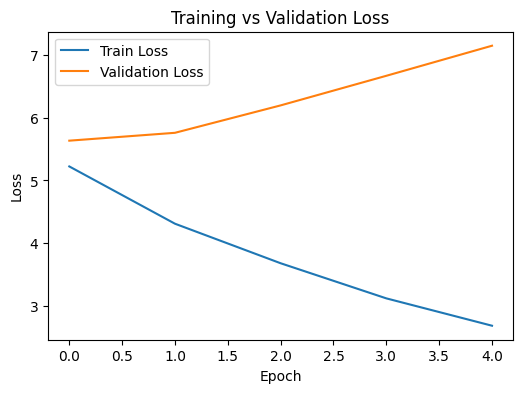

✅ Training complete. Best Val Perplexity: 279.3599936852663


In [57]:
train_model(
    train_loader, val_loader, vocab_size=len(vocab),
    embed_dim=128, hidden_dim=256, num_layers=2,
    dropout=0.3, lr=0.001, num_epochs=5,
    save_path="/content/drive/MyDrive/IIIT_Assignment2/results/model_bestfit.pth"
)


In [58]:
import torch
from src.model import LSTMLanguageModel

# Paths
best_model_path = "/content/drive/MyDrive/IIIT_Assignment2/results/model_bestfit.pth"

# Reload model
vocab_size = len(vocab)
model = LSTMLanguageModel(vocab_size)
model.load_state_dict(torch.load(best_model_path, map_location="cpu"))
model.eval()

# Create reverse mapping
idx2word = {idx: word for word, idx in vocab.items()}

# Generate sample text
seed_text = "Elizabeth was"
generated_text = model.generate(seed_text, vocab, idx2word, max_len=50)
print("Generated sample:\n", generated_text)


Generated sample:
 Elizabeth was <unk> to the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of


In [59]:
vocab = build_vocab(text_data, min_freq=1)

In [60]:
encoded = encode_text(text_data, vocab)
train_loader, val_loader = create_dataloaders(encoded, seq_len=30, batch_size=64)

Epoch 1 Training: 100%|██████████| 1757/1757 [00:27<00:00, 64.60it/s]


Epoch 1: Train Loss=5.6711, Val Loss=6.4141, Val PPL=610.39


Epoch 2 Training: 100%|██████████| 1757/1757 [00:27<00:00, 64.19it/s]


Epoch 2: Train Loss=4.6349, Val Loss=6.4370, Val PPL=624.55


Epoch 3 Training: 100%|██████████| 1757/1757 [00:27<00:00, 64.06it/s]


Epoch 3: Train Loss=3.8662, Val Loss=6.9475, Val PPL=1040.55


Epoch 4 Training: 100%|██████████| 1757/1757 [00:27<00:00, 64.00it/s]


Epoch 4: Train Loss=3.1615, Val Loss=7.5211, Val PPL=1846.64


Epoch 5 Training: 100%|██████████| 1757/1757 [00:27<00:00, 63.77it/s]


Epoch 5: Train Loss=2.6522, Val Loss=8.1152, Val PPL=3345.04


Epoch 6 Training: 100%|██████████| 1757/1757 [00:27<00:00, 63.90it/s]


Epoch 6: Train Loss=2.2848, Val Loss=8.6645, Val PPL=5793.75


Epoch 7 Training: 100%|██████████| 1757/1757 [00:27<00:00, 63.93it/s]


Epoch 7: Train Loss=2.0061, Val Loss=9.1403, Val PPL=9323.78


Epoch 8 Training: 100%|██████████| 1757/1757 [00:27<00:00, 63.91it/s]


Epoch 8: Train Loss=1.7873, Val Loss=9.5922, Val PPL=14650.74


Epoch 9 Training: 100%|██████████| 1757/1757 [00:27<00:00, 63.78it/s]


Epoch 9: Train Loss=1.6122, Val Loss=9.9611, Val PPL=21185.36


Epoch 10 Training: 100%|██████████| 1757/1757 [00:27<00:00, 63.94it/s]


Epoch 10: Train Loss=1.4703, Val Loss=10.2969, Val PPL=29641.65


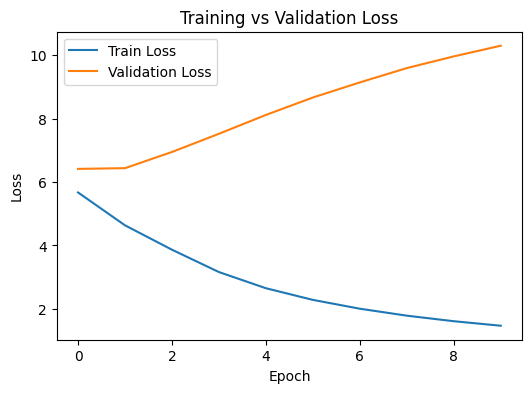

✅ Training complete. Best Val Perplexity: 610.3891055492325


In [61]:
train_model(
    train_loader, val_loader, vocab_size=len(vocab),
    embed_dim=128, hidden_dim=256, num_layers=2,
    dropout=0.3, lr=0.001, num_epochs=10,
    save_path="/content/drive/MyDrive/IIIT_Assignment2/results/model_bestfit_long.pth"
)


In [62]:
best_model_path = "/content/drive/MyDrive/IIIT_Assignment2/results/model_bestfit_long.pth"
vocab_size = len(vocab)

from src.model import LSTMLanguageModel
model = LSTMLanguageModel(vocab_size)
model.load_state_dict(torch.load(best_model_path, map_location="cpu"))
model.eval()
idx2word = {idx: word for word, idx in vocab.items()}

seed_text = "Elizabeth was"
generated_text = model.generate(seed_text, vocab, idx2word, max_len=50)
print("Improved sample:\n", generated_text)


Improved sample:
 Elizabeth was not to be so much to be so much to be so much to be so much to be so much to be so much to be so much to be so much to be so much to be so much to be so much to be so much to
